###  备注

#（1）【目的】：《阿里天池大赛_资金流入流出预测数据集》数据预处理，形成dataset
#（2）【Author】：shasha.mao
#（3）【日期】：2021/02/27
#（4）【数据】：
#（5）【路径】：.\data\Purchase Redemption Data
#（6）【备注】：
#（7）【更改】：初版 2020/02/27

### 总结

#判断有无缺失值，所有缺失值一律按0进行填充
#按日期对user_balance_table表进行了聚合
#按日期为主键进行了多表join
#对日期进行编码，0为工作日，1为周末但不是传统节日，2为传统节日
#最终的数据集按日期升序排列，并将数据集变为时间序列
#数据集的时间范围【20130701-2014.08.31】

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import util
import os
import sys
import datetime
import tqdm
import logging
import chinese_calendar

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

%matplotlib inline
sns.set()

In [2]:
print('运行时间 : ', datetime.datetime.now())

运行时间 :  2021-03-02 13:14:48.975363


### 数据集导入

#### 用户数据集和行为数据集 

In [3]:
# 用户信息表
user_profile_table = pd.read_csv(r"./data/Purchase Redemption Data/user_profile_table.csv")
print(user_profile_table.shape, user_profile_table.dropna().shape)
user_profile_table.head()

(28041, 4) (28041, 4)


,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座
3,23,1,6411949,双鱼座
4,25,1,6481949,双鱼座


In [4]:
# 用户申购赎回数据表,有缺失值
user_balance_table = pd.read_csv(r".\data\Purchase Redemption Data\user_balance_table.csv")
print(user_balance_table.shape, user_balance_table.dropna().shape)
user_balance_table.head()

(2840421, 18) (173739, 18)


,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


#user_balance_table表中的如下字段存在缺失值
#category1               True
#category2               True
#category3               True
#category4               True

In [5]:
user_balance_table.isnull().any()

user_id                False
report_date            False
tBalance               False
yBalance               False
total_purchase_amt     False
direct_purchase_amt    False
purchase_bal_amt       False
purchase_bank_amt      False
total_redeem_amt       False
consume_amt            False
transfer_amt           False
tftobal_amt            False
tftocard_amt           False
share_amt              False
category1               True
category2               True
category3               True
category4               True
dtype: bool

In [6]:
user_balance_table.dtypes

user_id                  int64
report_date              int64
tBalance                 int64
yBalance                 int64
total_purchase_amt       int64
direct_purchase_amt      int64
purchase_bal_amt         int64
purchase_bank_amt        int64
total_redeem_amt         int64
consume_amt              int64
transfer_amt             int64
tftobal_amt              int64
tftocard_amt             int64
share_amt                int64
category1              float64
category2              float64
category3              float64
category4              float64
dtype: object

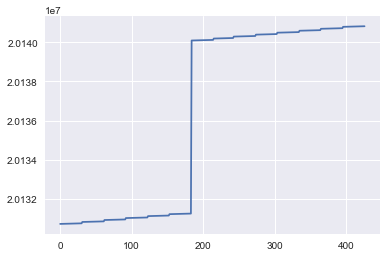

In [7]:
x = list(set(user_balance_table.report_date.sort_values()))
x.sort()

plt.plot(range(len(x)),x)

#### 公共数据集（都只提供到2014.08.29日）

In [8]:
# comp_predict_table = pd.read_csv(r".\data\Purchase Redemption Data\comp_predict_table.csv")  # 答题卡模板

In [9]:
# 上海银行间同业拆放利率表
mfd_bank_shibor = pd.read_csv(r".\data\Purchase Redemption Data\mfd_bank_shibor.csv")
print(mfd_bank_shibor.shape, mfd_bank_shibor.dropna().shape)
print(mfd_bank_shibor.mfd_date)
mfd_bank_shibor.head()

(294, 9) (294, 9)
0      20130701
1      20130702
2      20130703
3      20130704
4      20130705
5      20130708
6      20130709
7      20130710
8      20130711
9      20130712
10     20130715
11     20130716
12     20130717
13     20130718
14     20130719
15     20130722
16     20130723
17     20130724
18     20130725
19     20130726
20     20130729
21     20130730
22     20130731
23     20130801
24     20130802
25     20130805
26     20130806
27     20130807
28     20130808
29     20130809
         ...   
264    20140721
265    20140722
266    20140723
267    20140724
268    20140725
269    20140728
270    20140729
271    20140730
272    20140731
273    20140801
274    20140804
275    20140805
276    20140806
277    20140807
278    20140808
279    20140811
280    20140812
281    20140813
282    20140814
283    20140815
284    20140818
285    20140819
286    20140820
287    20140821
288    20140822
289    20140825
290    20140826
291    20140827
292    20140828
293    20140829
Name: 

,mfd_date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y
0,20130701,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125
1,20130702,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070
2,20130703,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022
3,20130704,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000
4,20130705,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000


In [10]:
# 收益率表
mfd_day_share_interest = pd.read_csv(r".\data\Purchase Redemption Data\mfd_day_share_interest.csv")
print(mfd_day_share_interest.shape, mfd_day_share_interest.dropna().shape)
print(mfd_day_share_interest.mfd_date.head())
mfd_day_share_interest.head()

(427, 3) (427, 3)
0    20130701
1    20130702
2    20130703
3    20130704
4    20130705
Name: mfd_date, dtype: int64


,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,20130701,1.5787,6.307
1,20130702,1.5461,6.174
2,20130703,1.4670,6.034
3,20130704,1.4223,5.903
4,20130705,1.3845,5.739


###  对用户行为表进行宏观统计

#### 用户个数分析 

In [11]:
user_profile_table.shape[0],len(set(user_balance_table.user_id))

(28041, 28041)

#### 数据预处理 

#用0填充缺失值

In [12]:
user_balance_table.head(2)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [13]:
user_balance_table_df = user_balance_table.fillna(0)
user_balance_table_df.dropna().shape,user_balance_table.shape

((2840421, 18), (2840421, 18))

#按日期分组，对tBalance、yBalance求平均，对其他字段求和

In [14]:
user_balance_table_analysis = user_balance_table_df.groupby("report_date").aggregate({'tBalance': "mean",
                                                                                        'yBalance': "mean",
                                                                                        'total_purchase_amt': "sum",
                                                                                        'direct_purchase_amt': "sum",
                                                                                        'purchase_bal_amt': "sum",
                                                                                        'purchase_bank_amt': "sum",
                                                                                        'total_redeem_amt': "sum",
                                                                                        'consume_amt': "sum",
                                                                                        'transfer_amt': "sum",
                                                                                        'tftobal_amt': "sum",
                                                                                        'tftocard_amt': "sum",
                                                                                        'share_amt': "sum",
                                                                                        'category1': "sum",
                                                                                        'category2': "sum",
                                                                                        'category3': "sum",
                                                                                        'category4': "sum"}).reset_index()

user_balance_table_analysis.head()

,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,20130701,572172.020408,511030.691610,32488348,32458786,21250722,11208064,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,20130702,580855.631250,525683.043750,29037390,29007510,16561183,12446327,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,20130703,601458.128257,558738.883768,27270770,27234156,20493660,6740496,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,20130704,596631.093690,573857.755258,18321185,18282230,12108178,6174052,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,20130705,589932.397059,573599.378676,11648749,11607991,6930431,4677560,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


### 多表join，每日一条记录：包括当前资金宏观统计数据、当前各种利率

In [15]:
for series in [mfd_bank_shibor.mfd_date,mfd_day_share_interest.mfd_date, user_balance_table_analysis.report_date]:
    print(len(set(series)))

294
427
427


In [16]:
# mfd_bank_shibor与mfd_day_share_interest.mfd_date join
temp_df = pd.merge(mfd_bank_shibor, mfd_day_share_interest, how="outer")
final_df = pd.merge(temp_df, user_balance_table_analysis,
                    left_on="mfd_date", right_on="report_date", how="outer").drop("mfd_date", axis="columns")

# 按日期排序
final_df.sort_values(by="report_date", ascending=True, inplace=True)
print(final_df.shape)
final_df.head()

(427, 27)


,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y,mfd_daily_yield,mfd_7daily_yield,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125,1.5787,6.307,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070,1.5461,6.174,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022,1.4670,6.034,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000,1.4223,5.903,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000,1.3845,5.739,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


#仅mfd_bank_shibor表中的值存在缺失字段，join后的df总共427行，说明正确

In [17]:
len(set(final_df.report_date))

427

In [18]:
final_df.isnull().any()

Interest_O_N            True
Interest_1_W            True
Interest_2_W            True
Interest_1_M            True
Interest_3_M            True
Interest_6_M            True
Interest_9_M            True
Interest_1_Y            True
mfd_daily_yield        False
mfd_7daily_yield       False
report_date            False
tBalance               False
yBalance               False
total_purchase_amt     False
direct_purchase_amt    False
purchase_bal_amt       False
purchase_bank_amt      False
total_redeem_amt       False
consume_amt            False
transfer_amt           False
tftobal_amt            False
tftocard_amt           False
share_amt              False
category1              False
category2              False
category3              False
category4              False
dtype: bool

#### 用0填充缺失值 

In [19]:
final_df.fillna(0, inplace=True)

### 对日期进行标识

In [20]:
# 将int64类型转化为datetime类型
date_series = final_df.report_date.apply(lambda x: str(x)).apply(pd.to_datetime)
final_df["year"] = date_series.apply(lambda x: x.year)
final_df["month"] = date_series.apply(lambda x: x.month)
final_df["day"] = date_series.apply(lambda x: x.day)

https://blog.csdn.net/z812215522/article/details/113257803

In [21]:
# 将int64类型转化为datetime类型
date_series = final_df.report_date.apply(lambda x: str(x)).apply(lambda x: datetime.date(int(x[0:4]), int(x[4:6]), int(x[6:])))
final_df["year"] = date_series.apply(lambda x: x.year)
final_df["month"] = date_series.apply(lambda x: x.month)
final_df["day"] = date_series.apply(lambda x: x.day)
# final_df["is_holiday"] = date_series.apply(chinese_calendar.is_holiday)
final_df["get_holiday_detail"] = date_series.apply(chinese_calendar.get_holiday_detail)
final_df["date"] = date_series  # datetime类型

def holiday_code(x):
    # 对日期进行编码，0为工作日，1为周末但不是传统节日，2为传统节日
    if x[0]:
        if x[1] is not None:
            return 2
        else:
            return 1
    else:
        return 0

final_df["holiday_detail"] = final_df.get_holiday_detail.apply(holiday_code)

### 去除无关列，并对列名进行排序

In [22]:
final_df.columns

Index(['Interest_O_N', 'Interest_1_W', 'Interest_2_W', 'Interest_1_M',
       'Interest_3_M', 'Interest_6_M', 'Interest_9_M', 'Interest_1_Y',
       'mfd_daily_yield', 'mfd_7daily_yield', 'report_date', 'tBalance',
       'yBalance', 'total_purchase_amt', 'direct_purchase_amt',
       'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt',
       'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt',
       'share_amt', 'category1', 'category2', 'category3', 'category4', 'year',
       'month', 'day', 'get_holiday_detail', 'date', 'holiday_detail'],
      dtype='object')

In [23]:
aim_col = ['report_date', 'date', 'year','month', 'day', 'holiday_detail', 'Interest_O_N', 'Interest_1_W', 'Interest_2_W', 'Interest_1_M',
           'Interest_3_M', 'Interest_6_M', 'Interest_9_M', 'Interest_1_Y',
           'mfd_daily_yield', 'mfd_7daily_yield', 'tBalance',
           'yBalance', 'total_purchase_amt', 'direct_purchase_amt',
           'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt',
           'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt',
           'share_amt', 'category1', 'category2', 'category3', 'category4']

save_df = pd.DataFrame(final_df, columns=aim_col)
save_df.set_index("date", inplace=True)
save_df.head()

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,20130701,2013,7,1,0,4.456,5.423,6.040,6.8800,5.295,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
2013-07-02,20130702,2013,7,2,0,3.786,4.750,5.074,5.8000,5.211,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2013-07-03,20130703,2013,7,3,0,3.400,4.242,4.658,5.2000,5.148,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
2013-07-04,20130704,2013,7,4,0,3.348,3.938,4.464,5.1020,5.029,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
2013-07-05,20130705,2013,7,5,0,3.380,3.816,4.295,4.7885,4.939,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


In [24]:
save_df.query("year==2013").head(2)

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,20130701,2013,7,1,0,4.456,5.423,6.040,6.88,5.295,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
2013-07-02,20130702,2013,7,2,0,3.786,4.750,5.074,5.80,5.211,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0


In [25]:
save_df.query("year==2013")

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,20130701,2013,7,1,0,4.4560,5.423,6.040,6.8800,5.2950,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
2013-07-02,20130702,2013,7,2,0,3.7860,4.750,5.074,5.8000,5.2110,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2013-07-03,20130703,2013,7,3,0,3.4000,4.242,4.658,5.2000,5.1480,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
2013-07-04,20130704,2013,7,4,0,3.3480,3.938,4.464,5.1020,5.0290,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
2013-07-05,20130705,2013,7,5,0,3.3800,3.816,4.295,4.7885,4.9390,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0
2013-07-06,20130706,2013,7,6,1,0.0000,0.000,0.000,0.0000,0.0000,...,1616635,300533,1316102,1316102,0,42082,0.0,21800.0,0.0,278733.0
2013-07-07,20130707,2013,7,7,1,0.0000,0.000,0.000,0.0000,0.0000,...,3982735,336880,3645855,3645855,0,41897,0.0,0.0,0.0,336880.0
2013-07-08,20130708,2013,7,8,0,3.2560,3.656,3.686,4.3000,4.7940,...,8347729,852530,7495199,7495199,0,39857,219851.0,3500.0,0.0,629179.0
2013-07-09,20130709,2013,7,9,0,3.2490,3.596,3.604,4.2980,4.7230,...,3473059,765509,2707550,2707550,0,42998,60000.0,0.0,0.0,705509.0


In [26]:
save_df.query("year==2014")

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,20140101,2014,1,1,2,0.0000,0.0000,0.0000,0.0000,0.0000,...,77367755,21750788,55616967,15782631,39834336,1370848,9463186.0,7180059.0,0.0,5107543.0
2014-01-02,20140102,2014,1,2,0,3.1310,4.9810,5.7590,5.9100,5.5657,...,190155450,22941048,167214402,26734732,140479670,1425250,6429483.0,6583823.0,0.0,9927742.0
2014-01-03,20140103,2014,1,3,0,3.0060,4.7110,5.5240,6.2010,5.5661,...,127714255,23841309,103872946,27165547,76707399,1434209,10507984.0,4191467.0,50000.0,9091858.0
2014-01-04,20140104,2014,1,4,1,0.0000,0.0000,0.0000,0.0000,0.0000,...,99869074,21965772,77903302,10496655,67406647,1478659,13162251.0,1833288.0,0.0,6970233.0
2014-01-05,20140105,2014,1,5,1,0.0000,0.0000,0.0000,0.0000,0.0000,...,156781996,20843557,135938439,37596243,98342196,1470907,12945726.0,2302192.0,0.0,5595639.0
2014-01-06,20140106,2014,1,6,0,2.9200,4.6330,5.4330,6.4750,5.5732,...,190917629,25009899,165907730,35042141,130865589,1451170,8546854.0,9726055.0,0.0,6736990.0
2014-01-07,20140107,2014,1,7,0,2.8750,4.2590,5.0740,5.9250,5.5760,...,137972793,27531206,110441587,23886191,86555396,1504036,11435514.0,3109835.0,0.0,12985857.0
2014-01-08,20140108,2014,1,8,0,2.8300,4.1260,4.9270,5.6500,5.5821,...,213880074,24398384,189481690,22175353,167306337,1626965,6934583.0,6375874.0,400000.0,10687927.0
2014-01-09,20140109,2014,1,9,0,2.7940,4.0200,4.7990,6.3140,5.5837,...,140391237,25855665,114535572,27071650,87463922,1640664,12014226.0,3339321.0,1350500.0,9151618.0


In [28]:
save_df.to_excel(r".\data\dateset.xlsx")